Convert Encoder, Diffusion model and Decoder to .tflite files and make inference

In [ ]:
!pip install -U tensorflow
!pip install keras-cv

In [ ]:
!apt-get install git-lfs

In [3]:
!find / -type d -name "keras_cv"

/usr/local/lib/python3.7/dist-packages/keras_cv
find: ‘/proc/97/task/97/net’: Invalid argument
find: ‘/proc/97/net’: Invalid argument


In [4]:
import tensorflow as tf
from tensorflow import keras
import base64
import math
import numpy as np

In [5]:
print(tf.__version__)

2.11.0


In [6]:
import matplotlib.pyplot as plt

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

In [7]:
%cd ../

/


In [8]:
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.constants import _UNCONDITIONAL_TOKENS
from keras_cv.models.stable_diffusion.constants import _ALPHAS_CUMPROD
MAX_PROMPT_LENGTH = 77
IMG_HEIGHT = 512
IMG_WIDTH = 512

Encoder

In [ ]:
!git lfs install
!git clone https://huggingface.co/keras-sd/tfs-text-encoder

In [ ]:
#!rm -r tfs-text-encoder

In [10]:
# Saved model format
encoder_model = tf.saved_model.load('/tfs-text-encoder')

In [ ]:
# How encoder model was saved
'''
# keras model
signature_dict = {
    "tokens": tf.TensorSpec(shape=[None, 77], dtype=tf.int32, name="tokens"),
    "batch_size": tf.TensorSpec(shape=[], dtype=tf.int32, name="batch_size"),
}


def text_encoder_exporter(model: tf.keras.Model):
    MAX_PROMPT_LENGTH = 77
    POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)
    UNCONDITIONAL_TOKENS = tf.convert_to_tensor([_UNCONDITIONAL_TOKENS], dtype=tf.int32)

    @tf.function(input_signature=[signature_dict])
    def serving_fn(inputs):
        batch_size = inputs["batch_size"]

        # context
        encoded_text = model([inputs["tokens"], POS_IDS], training=False)
        encoded_text = tf.squeeze(encoded_text)

        if tf.rank(encoded_text) == 2:
            encoded_text = tf.repeat(
                tf.expand_dims(encoded_text, axis=0), batch_size, axis=0
            )

        # unconditional context
        unconditional_context = model([UNCONDITIONAL_TOKENS, POS_IDS], training=False)

        unconditional_context = tf.repeat(unconditional_context, batch_size, axis=0)
        return {"context": encoded_text, "unconditional_context": unconditional_context}

    return serving_fn


tf.saved_model.save(
    text_encoder,
    "./text_encoder/1/",
    signatures={"serving_default": text_encoder_exporter(text_encoder)},
)
'''

In [ ]:
tokenizer = SimpleTokenizer()     
pos_ids = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

In [12]:
text_to_encode = "two cats doing research"
payload = {"inputs": text_to_encode, "batch_size": 1}

In [13]:
# Using encoder saved model

def encode_text(prompt):
  # Tokenize prompt (i.e. starting context)
  inputs = tokenizer.encode(prompt)
  print(inputs)
  if len(inputs) > MAX_PROMPT_LENGTH:
      raise ValueError(
          f"Prompt is too long (should be <= {MAX_PROMPT_LENGTH} tokens)"
      )
  phrase = inputs + [49407] * (MAX_PROMPT_LENGTH - len(inputs))
  print(phrase)
  phrase = tf.convert_to_tensor([phrase], dtype=tf.int32)

  context = encoder_model([phrase, pos_ids], training=False)

  return context

def _get_unconditional_context():
    unconditional_tokens = tf.convert_to_tensor(
        [_UNCONDITIONAL_TOKENS], dtype=tf.int32
    )
    unconditional_context = encoder_model([unconditional_tokens, pos_ids], training=False)

    return unconditional_context

def get_contexts(encoded_text, batch_size):
    encoded_text = tf.squeeze(encoded_text)
    if encoded_text.shape.rank == 2:
        encoded_text = tf.repeat(
            tf.expand_dims(encoded_text, axis=0), batch_size, axis=0
        )

    context = encoded_text

    unconditional_context = tf.repeat(
        _get_unconditional_context(), batch_size, axis=0
    )  

    return context, unconditional_context

prompt = payload.pop("inputs", payload)
batch_size = payload.pop("batch_size", 1)

encoded_text = encode_text(prompt)
print(encoded_text.shape)

context, unconditional_context = get_contexts(encoded_text, batch_size)
print(context)
print(unconditional_context.shape)

[49406, 1237, 3989, 1960, 2379, 49407]
[49406, 1237, 3989, 1960, 2379, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407]
(1, 77, 768)
tf.Tensor(
[[[-0.3883766   0.02294356 -0.05219658 ... -0.4898829  -0.30660197
    0.06745391]
  [ 1.8163824  -1.8569891   1.5186325  ...  0.10563207 -0.5995458
   -0.97468233]
  [ 0.38692623  0.22100082  1.7624433  ... -2.129387   -0.30890623
    0.00732522]
  ...
  [-2.1136909  -0.44626626  1.5587363  ... -0.36577848 -0.06864363
   -0.51862735]
  [-2.119036   -0.44160873  1.5576715  ... -0.37275904 -0.053842

In [14]:
# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model("/tfs-text-encoder") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('text_encoder.tflite', 'wb') as f:
  f.write(tflite_model)

In [15]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/text_encoder.tflite")
interpreter.allocate_tensors()

# Get input, output tensors and signatures.
input_details = interpreter.get_input_details()
print(input_details)
output_details = interpreter.get_output_details()
print(output_details)
signature_lists = interpreter.get_signature_list()
print(signature_lists)

# Get inputs
inputs = tokenizer.encode(text_to_encode)
phrase = inputs + [49407] * (MAX_PROMPT_LENGTH - len(inputs))
print(phrase)
phrase = tf.convert_to_tensor([phrase], dtype=tf.int32)
batch_size = 1
batch = tf.convert_to_tensor(batch_size, dtype=tf.int32)
# Set tensors
interpreter.set_tensor(input_details[0]['index'], batch)
interpreter.set_tensor(input_details[1]['index'], phrase)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
encoder_interpreter_context = interpreter.get_tensor(output_details[1]['index'])
print(encoder_interpreter_context)
encoder_interpreter_unconditional_context = interpreter.get_tensor(output_details[0]['index'])
print(encoder_interpreter_unconditional_context.shape)

[{'name': 'serving_default_batch_size:0', 'index': 0, 'shape': array([], dtype=int32), 'shape_signature': array([], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'serving_default_tokens:0', 'index': 1, 'shape': array([ 1, 77], dtype=int32), 'shape_signature': array([-1, 77], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:1', 'index': 3499, 'shape': array([1, 1, 1], dtype=int32), 'shape_signature': array([-1, -1, -1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype

Diffusion model

In [ ]:
!git clone https://huggingface.co/keras-sd/tfs-diffusion-model

In [17]:
diffusion_model = tf.saved_model.load('/tfs-diffusion-model')

In [ ]:
# How diffusion model was saved
'''
signature_dict = {
    "context": tf.TensorSpec(shape=[None, 77, 768], dtype=tf.float32, name="context"),
    "unconditional_context": tf.TensorSpec(
        shape=[None, 77, 768], dtype=tf.float32, name="unconditional_context"
    ),
    "num_steps": tf.TensorSpec(shape=[], dtype=tf.int32, name="num_steps"),
    "batch_size": tf.TensorSpec(shape=[], dtype=tf.int32, name="batch_size"),
}


def diffusion_model_exporter(model: tf.keras.Model):
    IMG_HEIGHT = 512
    IMG_WIDTH = 512
    MAX_PROMPT_LENGTH = 77
    _ALPHAS_CUMPROD_tf = tf.constant(_ALPHAS_CUMPROD)
    UNCONDITIONAL_GUIDANCE_SCALE = 7.5
    SEED = None

    @tf.function
    def get_timestep_embedding(timestep, batch_size, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return tf.repeat(embedding, batch_size, axis=0)

    @tf.function(input_signature=[signature_dict])
    def serving_fn(inputs):
        img_height = tf.cast(tf.math.round(IMG_HEIGHT / 128) * 128, tf.int32)
        img_width = tf.cast(tf.math.round(IMG_WIDTH / 128) * 128, tf.int32)

        batch_size = inputs["batch_size"]
        num_steps = inputs["num_steps"]

        context = inputs["context"]
        unconditional_context = inputs["unconditional_context"]

        latent = tf.random.normal((batch_size, img_height // 8, img_width // 8, 4))

        timesteps = tf.range(1, 1000, 1000 // num_steps)
        alphas = tf.map_fn(lambda t: _ALPHAS_CUMPROD_tf[t], timesteps, dtype=tf.float32)
        alphas_prev = tf.concat([[1.0], alphas[:-1]], 0)

        index = num_steps - 1
        latent_prev = None
        for timestep in timesteps[::-1]:
            latent_prev = latent
            t_emb = get_timestep_embedding(timestep, batch_size)
            unconditional_latent = model([latent, t_emb, unconditional_context], training=False)
            latent = model([latent, t_emb, context], training=False)
            latent = unconditional_latent + UNCONDITIONAL_GUIDANCE_SCALE * (
                latent - unconditional_latent
            )
            a_t, a_prev = alphas[index], alphas_prev[index]
            pred_x0 = (latent_prev - tf.math.sqrt(1 - a_t) * latent) / tf.math.sqrt(a_t)
            latent = (
                latent * tf.math.sqrt(1.0 - a_prev) + tf.math.sqrt(a_prev) * pred_x0
            )
            index = index - 1

        return {"latent": latent}

    return serving_fn


tf.saved_model.save(
    diffusion_model,
    "./diffusion_model/1/",
    signatures={"serving_default": diffusion_model_exporter(diffusion_model)},
)
'''

In [ ]:
# Using diffusion saved model

seed = None
img_height = 512
img_width = 512
img_height = round(img_height / 128) * 128
img_width = round(img_width / 128) * 128
num_steps = 25 
unconditional_guidance_scale = 7.5 

def _get_initial_diffusion_noise(batch_size, seed):
    if seed is not None:
        return tf.random.stateless_normal(
            (batch_size, img_height // 8, img_width // 8, 4),
            seed=[seed, seed],
        )
    else:
        return tf.random.normal(
            (batch_size, img_height // 8, img_width // 8, 4)
        )

def _get_initial_alphas(timesteps):
    alphas = [_ALPHAS_CUMPROD[t] for t in timesteps]
    alphas_prev = [1.0] + alphas[:-1]

    return alphas, alphas_prev

def _get_timestep_embedding(timestep, batch_size, dim=320, max_period=10000):
    half = dim // 2
    freqs = tf.math.exp(
        -math.log(max_period) * tf.range(0, half, dtype=tf.float32) / half
    )
    args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
    embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
    embedding = tf.reshape(embedding, [1, -1])
    return tf.repeat(embedding, batch_size, axis=0)

latent = _get_initial_diffusion_noise(batch_size, seed)

# Iterative reverse diffusion stage
timesteps = tf.range(1, 1000, 1000 // num_steps)
alphas, alphas_prev = _get_initial_alphas(timesteps)
progbar = keras.utils.Progbar(len(timesteps))
iteration = 0
for index, timestep in list(enumerate(timesteps))[::-1]:
    latent_prev = latent  # Set aside the previous latent vector
    t_emb = _get_timestep_embedding(timestep, batch_size)
    unconditional_latent = diffusion_model([latent, t_emb, unconditional_context], training = False)
    latent = diffusion_model([latent, t_emb, context], training = False)
    latent = unconditional_latent + unconditional_guidance_scale * (
        latent - unconditional_latent
    )
    a_t, a_prev = alphas[index], alphas_prev[index]
    pred_x0 = (latent_prev - math.sqrt(1 - a_t) * latent) / math.sqrt(a_t)
    latent = latent * math.sqrt(1.0 - a_prev) + math.sqrt(a_prev) * pred_x0
    iteration += 1
    progbar.update(iteration)

print(latent)

In [19]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/tfs-diffusion-model") # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model = converter.convert()
 
# Save the model.
with open('diffusion_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [21]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/diffusion_model.tflite")
interpreter.allocate_tensors()

# Get input, output tensors and signatures.
input_details = interpreter.get_input_details()
print(input_details)
output_details = interpreter.get_output_details()
print(output_details)
signature_lists = interpreter.get_signature_list()
print(signature_lists)

context_interpreter = tf.convert_to_tensor([encoder_interpreter_context[0]])
unconditional_context_interpreter = tf.convert_to_tensor([encoder_interpreter_unconditional_context[0]])
batch_size = 1
batch = tf.convert_to_tensor(batch_size, dtype=tf.int32)
num_steps = 25
n_steps = tf.convert_to_tensor(num_steps, dtype=tf.int32)

print(context_interpreter.shape)
# Set tensors
interpreter.set_tensor(input_details[0]['index'], unconditional_context_interpreter)
interpreter.set_tensor(input_details[1]['index'], context_interpreter)
interpreter.set_tensor(input_details[2]['index'], batch)
interpreter.set_tensor(input_details[3]['index'], n_steps)

interpreter.invoke()

output_data_latent = interpreter.get_tensor(output_details[0]['index'])
print(output_data_latent.shape)

[{'name': 'serving_default_unconditional_context:0', 'index': 0, 'shape': array([  1,  77, 768], dtype=int32), 'shape_signature': array([ -1,  77, 768], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'serving_default_context:0', 'index': 1, 'shape': array([  1,  77, 768], dtype=int32), 'shape_signature': array([ -1,  77, 768], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'serving_default_batch_size:0', 'index': 2, 'shape': array([], dtype=int32), 'shape_signature': array([], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=floa

Decoder

In [ ]:
!git clone https://huggingface.co/keras-sd/tfs-decoder

In [23]:
decoder_model = tf.saved_model.load('/tfs-decoder')

In [ ]:
# How decoder model was saved

'''
signature_dict = {
    "latent": tf.TensorSpec(shape=[None, 64, 64, 4], dtype=tf.float32, name="latent"),
}


def decoder_exporter(model: tf.keras.Model):
    @tf.function(input_signature=[signature_dict])
    def serving_fn(inputs):
        latent = inputs["latent"]
        decoded = model(latent, training=False)
        decoded = ((decoded + 1) / 2) * 255
        images = tf.clip_by_value(decoded, 0, 255)
        images = tf.cast(images, tf.uint8)
        return {"generated_images": images}

    return serving_fn

tf.saved_model.save(
    decoder,
    "./decoder/1/",
    signatures={"serving_default": decoder_exporter(decoder)},
)
'''

In [24]:
img_height = 512
img_width = 512
img_height = round(img_height / 128) * 128
img_width = round(img_width / 128) * 128

In [30]:
decoded = decoder_model(latent, training=False)
decoded = ((decoded + 1) / 2) * 255
images = np.clip(decoded, 0, 255).astype("uint8")

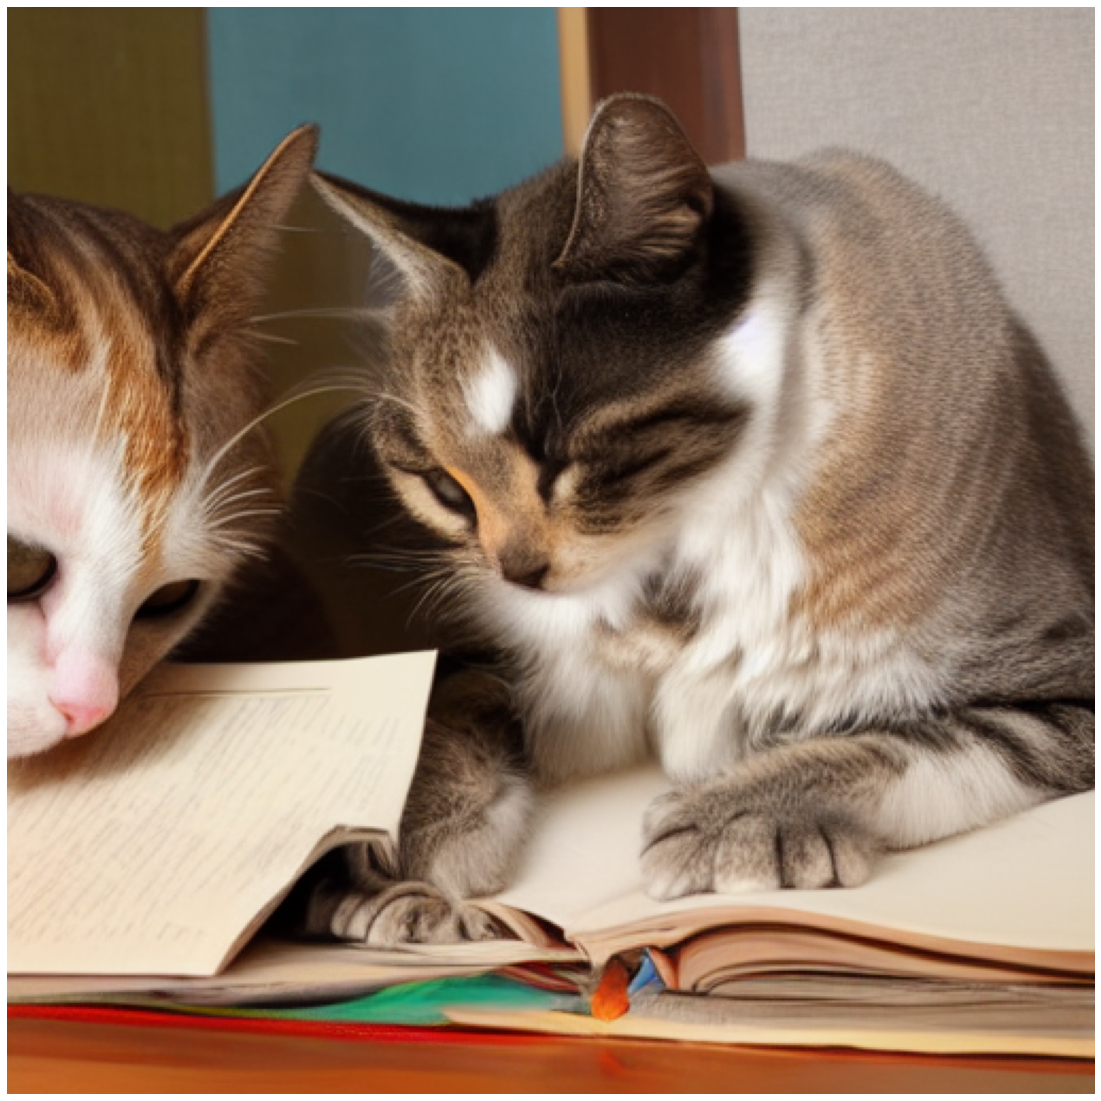

In [31]:
plot_images(images)

In [27]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/tfs-decoder") # path to the SavedModel directory
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Save the model.
with open('decoder.tflite', 'wb') as f:
  f.write(tflite_model)

In [32]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/decoder.tflite")
interpreter.allocate_tensors()

# Get input, output tensors and signatures.
input_details = interpreter.get_input_details()
print(input_details)
output_details = interpreter.get_output_details()
print(output_details)
signature_lists = interpreter.get_signature_list()
print(signature_lists)

latent_interpreter = tf.convert_to_tensor(output_data_latent)

print(context_interpreter.shape)
# Set tensors
interpreter.set_tensor(input_details[0]['index'], latent_interpreter)

interpreter.invoke()

output_images = interpreter.get_tensor(output_details[0]['index'])
print(output_images.shape)

[{'name': 'serving_default_latent:0', 'index': 0, 'shape': array([ 1, 64, 64,  4], dtype=int32), 'shape_signature': array([-1, 64, 64,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 1544, 'shape': array([1, 1, 1, 3], dtype=int32), 'shape_signature': array([-1, -1, -1,  3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
{'serving_default': {'inputs': ['latent'], 'outputs': ['generated_images']}}
(1, 77, 768)
(1, 512, 512, 3)


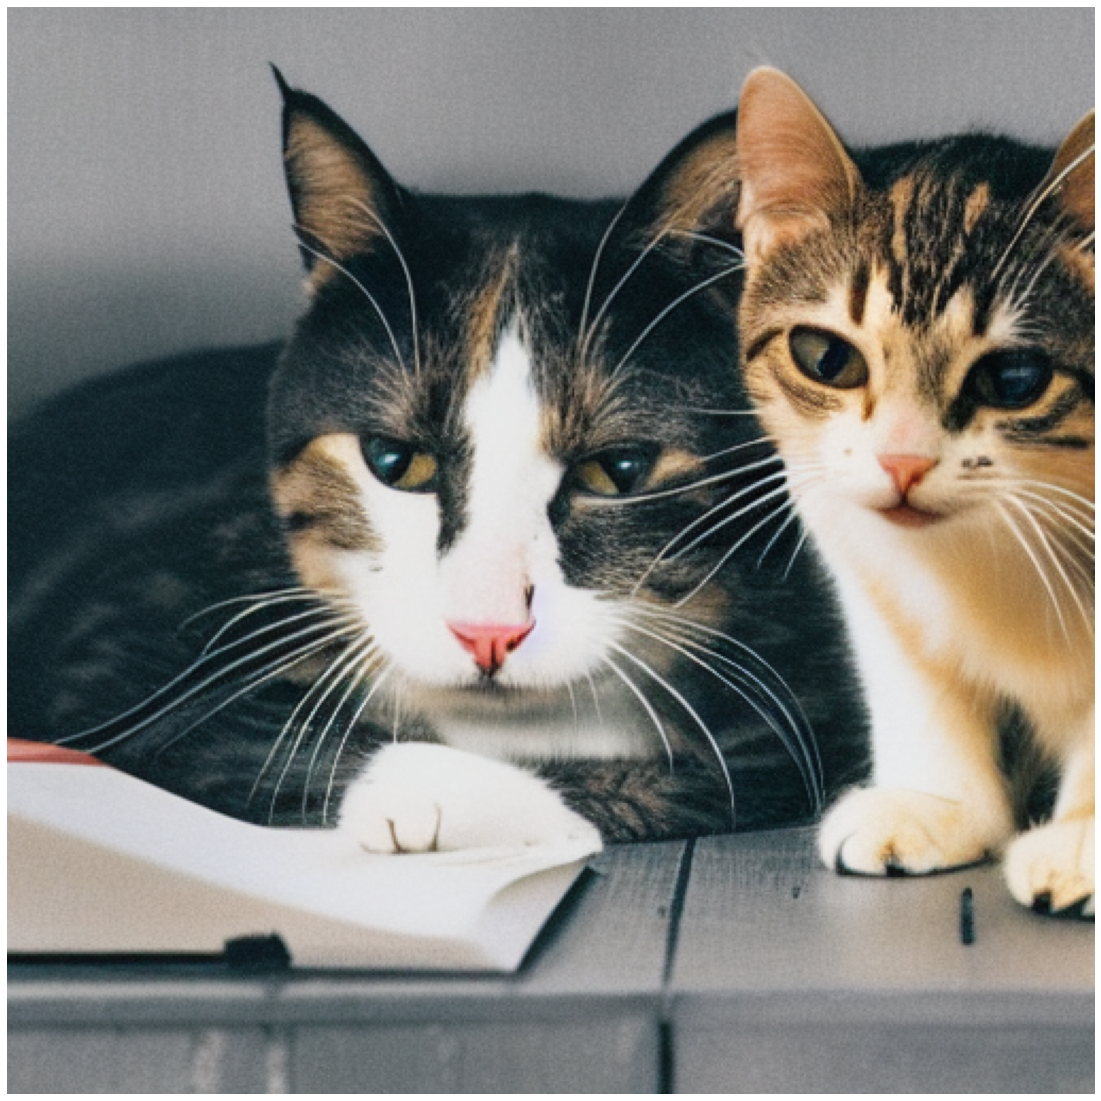

In [33]:
plot_images(output_images)